In [20]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from gymnasium import Env
from gymnasium.spaces import Box, Dict, Tuple, MultiDiscrete, Sequence
import ray
from ray import rllib
import pyarrow.parquet as pq
import ast

ValueError: mutable default <class 'ray.data._internal.execution.interfaces.ExecutionResources'> for field resource_limits is not allowed: use default_factory

In [ ]:
class Architecture:
    def __init__(self):
        self.space_flag = 0
        self.c_capacity, self.s_capacity = 1000, 100                                         # Capacity of the devices
        # self.a1, self.a2, self.a3, self.mc = 0.000125, 0.000010, 0.000200, 0.001           # Weight of every type of data
        self.weights = [0.0125, 0.0010, 0.0200, 0.1000]                                      # a1, a2, a3, mc
        self.lifetime = {'a1': 10000, 'a2': 20000, 'a3': 10000, 'mc': 1000}                  # Max lifetime of the different data types
        self.total_c = 2
        self.total_s = 6
        self.max_actions = 20

        self.devices = {}
        self.data = {
            'a1': {},
            'a2': {},
            'a3': {},
            'mc': {},
        }
        self.latencies = {}

        for i in range(self.total_c):
            for j in (self.data.keys()):
                self.data[j]['c'+str(i)] = 0
            self.devices['c'+str(i)] = {'a1': 0, 'a2': 0, 'a3': 0, 'mc': 0}
            self.latencies['c'+str(i)] = {}
        for i in range(self.total_s):
            for j in (self.data.keys()):
                self.data[j]['s'+str(i)] = 0
            self.devices['s'+str(i)] = {'a1': 0, 'a2': 0, 'a3': 0, 'mc': 0}
            self.latencies['s'+str(i)] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.data_allocation_dict = []

        self.action_type = []
        self.action_device_dev = []
        self.action_device = []

        randomized = list(self.devices.keys())
        random.shuffle(randomized)

        bound = round(len(self.devices)/4)

        self.clusters = {
            'a1': randomized[:bound],
            'a2': randomized[bound:bound*2],
            'a3': randomized[bound*2:bound*3],
            'mc': randomized[bound*3:]
        }

        self.visualization()

    def to_int(self, device):
        return list(self.devices.keys()).index(device)

    def to_int_type(self, type):
        return list(self.data.keys()).index(type)

    def to_device(self, position):
        return list(self.devices.keys())[position]

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation_dict,self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation_dict.append(device)
        self.data_allocation.append(self.to_int(device))
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation_dict[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation_dict[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation_dict.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in self.devices.keys():
            if list(i)[0] == 'c':
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= 0.2:
                self.space_flag = i
        return load

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.total_c]
        ss = keys[self.total_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.total_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.total_c)+len(ss)%self.total_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        plt.title("Architecture:")
        plt.axis('off')
        plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device_dev[i]].values())])
        return total_latency

    def generate(self, operation):
        if operation == 'a1' or operation == 'a2' or operation == 'a3':
            for i in self.devices.keys():
                self.update(operation,i)
        elif operation == 'mc':
            for i in self.devices.keys():
                if list(i)[0] == 's':
                    self.update('mc',i)
        elif operation.split('_')[0] == 'ai':
            device=random.sample(list(self.clusters[operation.split('_')[1]]),1)
            self.action_device_dev.append(device[0])
            self.action_device.append(self.to_int(device[0]))
            self.action_type.append(operation.split('_')[1])
            difference = len(self.action_device_dev) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device_dev.pop(0)
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def rl_update(self, allocation):
        allocation_dict = []
        for i in allocation:
            allocation_dict.append(self.to_device(i))
        self.data_allocation = allocation
        self.data_allocation_dict =allocation_dict
        self.construct_dictionaries()
        return self.free_space()

    def greedy_algorithm(self): # baseline?
        if self.space_flag == 0:
            allocation = []
            allocation_dev = []
            for i in self.data_types:
                allocation.append(self.to_int(random.sample(list(self.clusters[i]),1)[0]))
                allocation_dev.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation
            self.data_allocation_dict = allocation_dev
            self.construct_dictionaries()
            result = self.free_space()
        else:
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            self.clusters[problematic_key].extend(element for element in self.devices if element[0]==('c'))
            self.space_flag = 0
            result = self.greedy_algorithm()

        return result

In [3]:
class SimulatedArchitecture(Env):
    def __init__(self, architecture, num_devices):
        self.arch = architecture
        self.num_devices = num_devices
        self.weights = np.array(self.arch.weights, dtype=np.float32)
        self.free_space = np.array(list(self.arch.free_space().values()), dtype=np.float32)
        self.reward = 0
        self.executions = ['a1','a2','mc','a1','ai_a2','mc','a3','ai_a1','mc','a1','ai_a3','mc','a2','a3','ai_a2','mc','ai_a1','a1','mc','ai_a3','ai_mc']
        self.len_executions = len(self.executions)
        self.index = 0
        self.allocation = np.array([self.arch.data_types,self.arch.data_allocation], dtype=np.int32)
        self.last_calls = np.array([self.arch.action_type,self.arch.action_device], dtype=np.int32)
        self.observation_space = Dict(
            {"weights": Box(low=0, high=1, shape=(4,), dtype=np.float32),
             "free_space": Box(low=0, high=1, shape=(self.num_devices,), dtype=np.float32),
             "allocation": Box(low=0,high=self.num_devices,shape=(2,len(self.arch.data_types)),dtype=np.int32),
             "last_calls": Box(low=0,high=self.num_devices,shape=(2,len(self.arch.action_type)),dtype=np.int32)
             }
        )
        self.action_space = Box(low=0, high=self.num_devices-1, dtype=np.int32)
    def get_obs(self):
        return {"weights": self.weights,
                "free_space": self.free_space,
                "allocation": self.allocation,
                "last_calls": self.last_calls
                }
    def step(self, action):
        self.free_space = np.array(list(self.arch.rl_update(list(action)).values()), dtype=np.float32)
        latency = self.arch.compute_total_latency()
        self.reward = 0

        for i in self.free_space:
            if i <= 0.2:
                self.reward = -10
                break

        if self.reward != -10:
            self.reward = 4000000*(1/(latency+1)) + 0.5*(1/(np.std(self.free_space)+0.00001))              # With those weights, the scale of both latency and std is the same for high values while the latency is the only one taken into account in initial states (when there is plenty of space in the system and distribution is not that important)
        info = {}
        done = True

        obs = self.get_obs()

        self.observation_space['allocation'] = Box(low=0,high=self.num_devices,shape=(2,len(self.allocation[0])),dtype=np.int32)
        self.observation_space['last_calls'] = Box(low=0,high=self.num_devices,shape=(2,len(self.last_calls[0])),dtype=np.int32)

        return obs, self.reward, done, info

    def render(self):
        pass
    def reset(self):
        if self.reward != -10:
            self.arch.generate(self.executions[self.index])
            self.arch.heart_beat()
            self.index = self.index + 1 if self.index < self.len_executions-1 else 0
        data_types = []
        for i in self.arch.data_types:
            data_types.append(self.arch.to_int_type(i))
        self.allocation = np.array([data_types,self.arch.data_allocation], dtype=np.int32)
        action_types = []
        for i in self.arch.action_type:
            self.arch.to_int_type(i)
        self.last_calls = np.array([action_types,self.arch.action_device], dtype=np.int32)
        self.observation_space['allocation'] = Box(low=0,high=self.num_devices,shape=(2,len(self.allocation[0])),dtype=np.int32)
        self.observation_space['last_calls'] = Box(low=0,high=self.num_devices,shape=(2,len(self.last_calls[0])),dtype=np.int32)
        self.action_space = Box(low=0, high=self.num_devices-1, shape=(len(self.allocation[1]),), dtype=np.int32)
        return self.get_obs()
    def close(self):
        pass

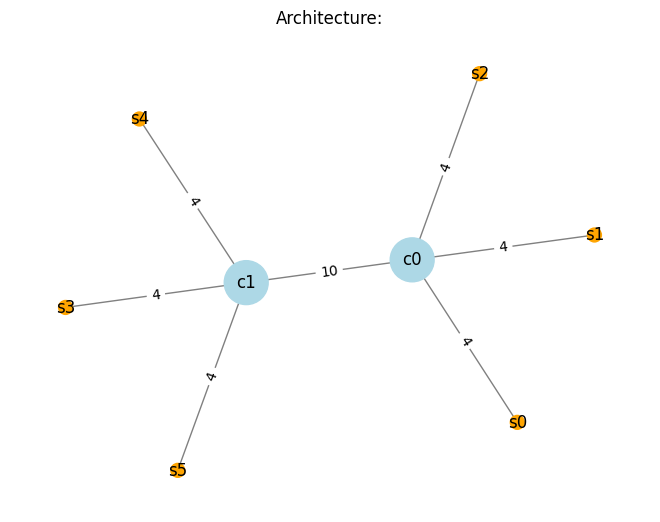

2023-05-31 13:02:00,254	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-05-31 13:02:00,256	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [4]:
from ray.rllib.utils import check_env
from gymnasium.wrappers import EnvCompatibility

architecture = Architecture()
simulated_aces = SimulatedArchitecture(architecture,8)
check_env(EnvCompatibility(simulated_aces))

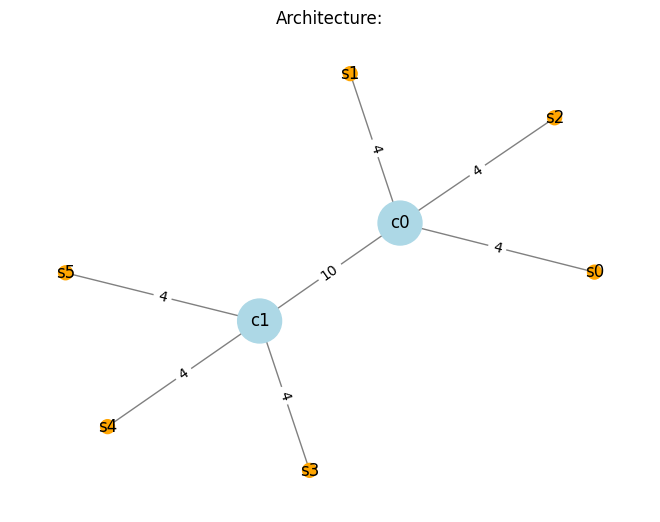

In [5]:
arch = Architecture()
simulation = SimulatedArchitecture(arch, 8)
# for i in range(1000):
#     simulation.reset()
#     simulation.step(simulation.action_space.sample())
# simulation.reset()
# simulation.step(simulation.action_space.sample())

In [6]:
def getData():
    observations_file_path = 'TFM/observations.csv'
    next_observations_file_path = 'TFM/next_observations.csv'
    actions_file_path = 'TFM/actions.parquet'
    rewards_file_path = 'TFM/rewards.parquet'

    observations_pd = pd.read_csv(observations_file_path)
    observations = observations_pd.to_dict(orient='records')
    next_observations_pd = pd.read_csv(next_observations_file_path)
    next_observations = next_observations_pd.to_dict(orient='records')
    actions_table = pq.read_table(actions_file_path)
    rewards_table = pq.read_table(rewards_file_path)
    actions = np.array(actions_table.to_pandas())
    rewards = np.array(rewards_table.to_pandas())

    return {"observations": observations, "actions":actions, "rewards": rewards, "next_observations":next_observations}

def processing(dataset):
    for i in range(len(dataset)):
        offline_dataset['observations'][i]["weights"] = ast.literal_eval(offline_dataset['observations'][i]["weights"])
        offline_dataset['observations'][i]["free_space"] = ast.literal_eval(offline_dataset['observations'][i]["free_space"])
        offline_dataset['observations'][i]['allocation'] = ast.literal_eval(offline_dataset['observations'][i]['allocation'])
        offline_dataset['observations'][i]["last_calls"] = ast.literal_eval(offline_dataset['observations'][i]["last_calls"])
        offline_dataset['next_observations'][i]["weights"] = ast.literal_eval(offline_dataset['next_observations'][i]["weights"])
        offline_dataset['next_observations'][i]["free_space"] = ast.literal_eval(offline_dataset['next_observations'][i]["free_space"])
        offline_dataset['next_observations'][i]['allocation'] = ast.literal_eval(offline_dataset['next_observations'][i]['allocation'])
        offline_dataset['next_observations'][i]["last_calls"] = ast.literal_eval(offline_dataset['next_observations'][i]["last_calls"])

In [8]:
offline_dataset = getData()

In [9]:
processing(offline_dataset)

In [7]:
class ACESEnv(Env):
    def __init__(self, latencies, content):

        # print('INIT')

        self.action_space = Box(low=0, high=4, shape=(3,), dtype=np.int32)

        self.observation_space = Dict({
            "allocation": Box(low=0, high=4, shape=(3,), dtype=np.int32),
            "users": Box(low=0, high=4, shape=(20,), dtype=np.int32),
            "content": Box(low=0, high=1, shape=(20, 3), dtype=np.int32)
        })

        self.num_servers = self.action_space.high[0] + 1

        # self.content = self.observation_space["content"].sample()
        # self.content = content

        self.latencies = latencies

    def _get_obs(self):
        return {"allocation": self.allocation, "users": self.users, "content": self.content}

    def getServerWeights(self):
        users_in_servers = []

        for i in range(self.num_servers):
            users_in_servers.append(np.where(self.users == i)[0])

        servers_weights = []

        for i in range(len(users_in_servers)):
            servers_weights.append(np.zeros(len(self.content[0])))
            for j in users_in_servers[i]:
                servers_weights[i] = servers_weights[i] + self.content[j]

        maximum_weights = np.amax(servers_weights, axis=0)

        # set_array = [set() for _ in range(self.content.shape[1])]
        changed_dims = np.array(list(zip(*servers_weights)))

        interested_servers = []
        for i in range(len(maximum_weights)):
            interested_servers.append(np.where(changed_dims[i] == maximum_weights[i])[0][0])

        # for i in range(len(servers_weights)):
        #     indexes = np.where(maximum_weights == servers_weights[i])[0]
        #     print("Indexes: "+str(indexes))
        #     for j in indexes:
        #         set_array[j].add(i)

        return interested_servers

    def calculate_latency(self, new_allocation):
        total_latency = 0
        users = self.users
        allocation = new_allocation
        content = self.content

        for i in range(len(users)):
            for j in range(len(content[i])):
                if (content[i][j] == 1 and users[int(i)] != allocation[int(j)]):
                    total_latency += self.latencies[str(users[i])][str(allocation[j])]

        return total_latency

    def step(self, action):

        # print('STEP')

        insterested_servers = self.getServerWeights()

        reward = 1 if self.calculate_latency(action) <= self.calculate_latency(insterested_servers) else 0

        self.allocation = action

        done = True

        info = {}

        return self._get_obs(), reward, done, info

    def render(self):

        pass

    def reset(self):

        # print('RESET')

        self.allocation = self.observation_space["allocation"].sample()
        self.users = self.observation_space["users"].sample()
        self.content = self.observation_space["content"].sample()

        return self._get_obs()

    def close(self):

        print('CLOSE')


def generate_latencies(num_servers):
    lat = {}
    for i in range(num_servers):
        lat[str(i)] = {}
        for j in range(num_servers):
            if i == j:
                lat[str(i)][str(j)] = 0
            else:
                if str(j) in lat:
                    lat[str(i)][str(j)] = lat[str(j)][str(i)]
                else:
                    lat[str(i)][str(j)] = random.randrange(0, 200, 5)
    return lat

latencies = generate_latencies(8)
custom_content = np.array([[1,1,0,0,1],[1,0,1,0,1]], dtype="int32")

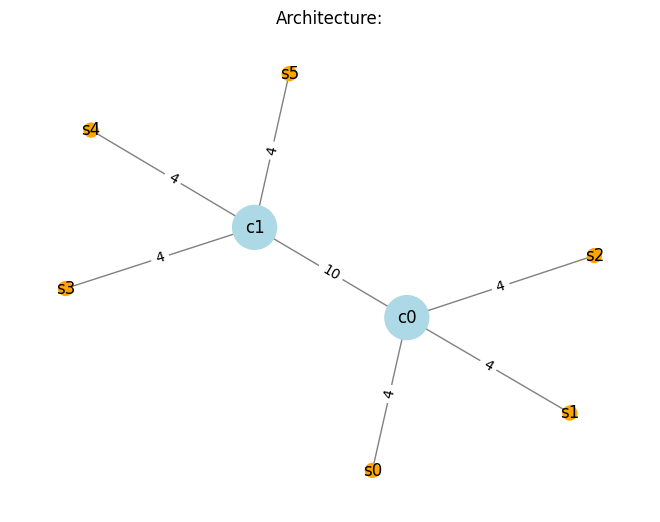

2023-05-31 13:02:54,040	INFO worker.py:1553 -- Started a local Ray instance.
(RolloutWorker pid=4159106) /home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/models/tf/misc.py:17: RuntimeWarning: divide by zero encountered in divide
(RolloutWorker pid=4159106)   out *= std / np.sqrt(np.square(out).sum(axis=0, keepdims=True))
(RolloutWorker pid=4159106) [2023-05-31 13:03:02,491 E 4159106 4159382] logging.cc:97: Unhandled exception: N4dnnl5errorE. what(): could not create a descriptor for an inner product forward propagation primitive
(RolloutWorker pid=4159106) [2023-05-31 13:03:02,535 E 4159106 4159383] logging.cc:97: Unhandled exception: N4dnnl5errorE. what(): could not create a descriptor for an inner product forward propagation primitive
(RolloutWorker pid=4159106) [2023-05-31 13:03:02,621 E 4159106 4159382] logging.cc:104: Stack trace: 
(RolloutWorker pid=4159106)  /home/rcalzada/.local/lib/python3.10/site-packages/ray/_raylet.so(+0xd508da) [0x7f65477508da] ray::operator<<(

KeyboardInterrupt: 

In [8]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit
import ray

ray.shutdown()
architecture = Architecture()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(SimulatedArchitecture(architecture,8)), max_episode_steps=10)
def env_creator_test(env_config):
    return TimeLimit(EnvCompatibility(ACESEnv(latencies,custom_content)), max_episode_steps=10)

register_env("ACES", env_creator)
register_env("ACESTest", env_creator_test)

config = (
    PPOConfig()
    .environment("ACES",disable_env_checking=True)
    # .framework("tf2")
    .rollouts(num_rollout_workers=1,
              num_envs_per_worker=1) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)

algorithm = config.build()

for i in tqdm(range(10)):
    result = algorithm.train()